In [1]:
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler,Imputer
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

In [2]:
spark = SparkSession.builder.appName('df-project').getOrCreate()


In [99]:
csv = spark.read.csv("/content/housing.csv",inferSchema=True, header=True)
csv.show()


+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

In [100]:
csv=csv.withColumnRenamed("median_house_value", "label")
csv.show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+--------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|   label|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+--------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|341300.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1627.0|         280.0|     565.0|     259.0|       3.8462|34

In [72]:
csv.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in csv.columns]).show()


+---------+--------+------------------+-----------+--------------+----------+----------+-------------+-----+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|label|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+-----+---------------+
|        0|       0|                 0|          0|           207|         0|         0|            0|    0|              0|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+-----+---------------+



In [91]:
imputer = Imputer(
    inputCols=['total_bedrooms'],
    outputCols=['total_bedrooms']
).setStrategy("mean")

indexer = StringIndexer(inputCol="ocean_proximity", outputCol="ocean_proximity_index")
encoder = OneHotEncoder(inputCol="ocean_proximity_index", outputCol="ocean_proximity_encoded")


feature_columns = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
                   'total_bedrooms', 'population', 'households', 'median_income',
                   'ocean_proximity_encoded']

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")


gbt = GBTRegressor(featuresCol="features", labelCol="label", maxIter=50)
pipeline = Pipeline(stages=[imputer, indexer, encoder, assembler, gbt])





In [92]:
train, test = csv.randomSplit([0.7, 0.3])
test = test.withColumnRenamed("label", "trueLabel")
train_rows = train.count()
test_rows = test.count()
print("Training Rows:", train_rows, " Testing Rows:", test_rows)

Training Rows: 14435  Testing Rows: 6205


In [95]:
pipeline_model = pipeline.fit(train)


In [96]:
prediction = pipeline_model.transform(test)
predicted = prediction.select("features", "prediction", "trueLabel")
predicted = predicted.withColumn("id",monotonically_increasing_id())
predicted.show()

+--------------------+------------------+---------+---+
|            features|        prediction|trueLabel| id|
+--------------------+------------------+---------+---+
|[-124.3,41.84,17....|127300.32218310301| 103600.0|  0|
|[-124.26,40.58,52...| 91119.55800103654| 111400.0|  1|
|[-124.23,41.75,11...|105022.05359998252|  73200.0|  2|
|[-124.21,41.75,20...| 93214.88987855092|  66900.0|  3|
|[-124.19,40.78,37...| 73932.98701138745|  70000.0|  4|
|[-124.19,41.78,15...| 80892.16741126693|  74600.0|  5|
|[-124.18,40.78,33...|100589.82767554854|  72200.0|  6|
|[-124.18,40.78,34...| 49469.35399962869|  67000.0|  7|
|[-124.18,40.79,39...| 57272.33843743611|  70500.0|  8|
|[-124.18,40.79,40...|51215.721473306054|  64600.0|  9|
|[-124.17,40.74,17...|131817.00988264545| 128900.0| 10|
|[-124.17,40.76,26...| 101186.9164039884|  82800.0| 11|
|[-124.17,40.79,43...| 75469.71484086414|  70500.0| 12|
|[-124.17,40.8,52....| 78733.74732504658|  60000.0| 13|
|[-124.17,41.76,20...|110450.15699264125| 105900

<Axes: xlabel='trueLabel', ylabel='prediction'>

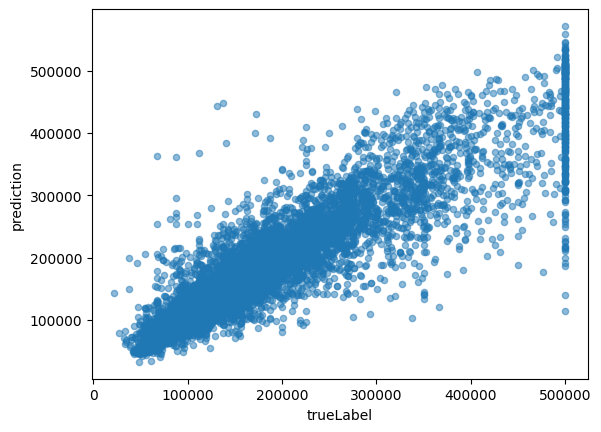

In [97]:
df = predicted.toPandas()
df.plot.scatter(x='trueLabel', y='prediction', alpha = 0.5)

In [98]:
evaluator = RegressionEvaluator(labelCol="trueLabel", predictionCol="prediction",
metricName="rmse")
rmse = evaluator.evaluate(prediction)
print("Root Mean Square Error (RMSE):", rmse)

Root Mean Square Error (RMSE): 52877.148818324014
